### Cactus Image Classification with Convolutional Neural Networks ###
#### Objective:
To use Convolutional neural networks as a binary classifier to classify a large resized(32x32) set of thumbnail images containing aerial photos of a columnar cactus (Neobuxbaumia tetetzo) as having cactus or not.
#### Context:
To assess the impact of climate change on Earth's flora and fauna, it is vital to quantify how human activities such as logging, mining, and agriculture are impacting our protected natural areas. Researchers in Mexico have created the VIGIA project, which aims to build a system for autonomous surveillance of protected areas. A first step in such an effort is the ability to recognize the vegetation inside the protected areas. The aim of the task is the creation of an algorithm that can identify a specific type of cactus in aerial imagery.
Link to the data set: https://www.kaggle.com/c/aerial-cactus-identification
#### Data Set:
The data set contains a set of 17500 resized training images (32x32 pixels) of aerial shots of cactus. The name of an image represents its id. A .csv file is available containing two columns, one with the ids of the images and second column corresponding to the value of the image having cactus or not. 

### Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import PIL
from PIL import Image
import os
from matplotlib import image
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import precision_score, roc_auc_score, recall_score, roc_curve

from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.metrics import BinaryAccuracy

#### Importing and displaying two sample images with and without a cactus, for an overview of the image set

In [2]:
## importing 2 sample images from the training set
train_images = os.path.join("data","train")
image1 = image.imread(os.path.join(train_images,"000c8a36845c0208e833c79c1bffedd1.jpg"))
image2 = image.imread(os.path.join(train_images,"002134abf28af54575c18741b89dd2a4.jpg"))
print("data type and shape of Image 1 with cactus :",image1.dtype,image1.shape)
print("data type and shape of Image 2 with no cactus :",image2.dtype,image2.shape)

data type and shape of Image 1 with cactus : uint8 (32, 32, 3)
data type and shape of Image 2 with no cactus : uint8 (32, 32, 3)


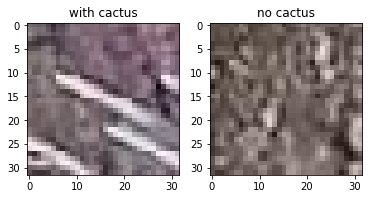

In [3]:
## plotting the 2 images
fig,ax = plt.subplots(1,2)
ax[0].imshow(image1)
ax[0].set_title("with cactus")
ax[1].imshow(image2)
ax[1].set_title("no cactus");

### Reading the train csv data file
The __'id'__ column shows the image id and the __'has_cactus'__ column shows whether the image has cactus(1) or does not(0).

In [4]:
data = pd.read_csv("data/train.csv")
data.sample(5)

,id,has_cactus
8525,7a4bb5ab23d78747c5ae0e1ada4d28ea.jpg,1
15556,e311cb3b5700b728bde6cd422e843960.jpg,1
4975,47586bdbc05adb8560738004aaad1f46.jpg,1
13196,bf7ff43ea8796e2cb1bcd8dbe9e6c8c3.jpg,1
1003,0e6641e7805227441d95666081217a7e.jpg,1


In [5]:
data.shape

(17500, 2)

In [6]:
data['has_cactus'].value_counts(normalize=True)

1    0.750629
0    0.249371
Name: has_cactus, dtype: float64

> *One can see that the images with cactus is almost 3 times more than those without cactus. Hence stratified shuffle split would be used.*

#### Importing all the images as numpy arrays and storing them into datax. Storing the corresponding has_cactus values into datay

In [7]:
datax = []
datay = []

for id in data['id'].values:
    datax.append(image.imread(os.path.join(train_images,id)))  
    datay.append(data['has_cactus'].loc[data['id'] == id].values[0]) 

datax = np.asarray(datax)
datay = np.asarray(datay)
print(datax.shape)
print(datay.shape)

(17500, 32, 32, 3)
(17500,)


In [8]:
print(datax[0][3][2])

[107 107  99]


### Splitting the data into train and test sets

In [9]:
sfs = StratifiedShuffleSplit(n_splits =1, test_size=0.3, random_state=42)
train_idx, test_idx = next(sfs.split(datax,datay))

x_train = datax[train_idx]
x_test = datax[test_idx]
y_train = data.loc[train_idx,'has_cactus']
y_test = data.loc[test_idx,'has_cactus']

print('shape of x_train is',x_train.shape)
print('shape of y_train is',y_train.shape)
print('shape of x_test is',x_test.shape)
print('shape of y_test is',y_test.shape)

shape of x_train is (12250, 32, 32, 3)
shape of y_train is (12250,)
shape of x_test is (5250, 32, 32, 3)
shape of y_test is (5250,)


#### Checking for imbalance in the split data

In [10]:
print("Distribution in y_train : \n{}".format(y_train.value_counts(normalize=True)))
print("\nDistribution in y_test : \n{}".format(y_test.value_counts(normalize=True)))

Distribution in y_train : 
1    0.750612
0    0.249388
Name: has_cactus, dtype: float64

Distribution in y_test : 
1    0.750667
0    0.249333
Name: has_cactus, dtype: float64


### Feature Engineering
#### Converting the target classes into categorical items

In [11]:
num_classes = 2
y_train_C = to_categorical(y_train,num_classes)
y_test_C = to_categorical(y_test,num_classes)

In [12]:
y_train_C

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

#### Scaling the x data

In [13]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train_sc = x_train/255
x_test_sc = x_test/255

In [14]:
print("First Pixel in original x train data: {}".format(x_train[0][0][0]))
print("Corresponding scaled Pixel: {}".format(x_train_sc[0][0][0]))

First Pixel in original x train data: [130. 113. 106.]
Corresponding scaled Pixel: [0.50980395 0.44313726 0.41568628]


In [15]:
x_train.shape[1:]

(32, 32, 3)

### Convolutional Neural Network Models
First, 3 different basic variations of the CNN models as listed below would be used to train and classify the cactus images. Here for the performance metrics, __precision__ will be the deciding factor in predicting how many out of the positive predictions, actually are true positives. Besides __recall and roc-auc score__ would also be used.  

|Model|Deep Layers|Final Activation|Loss Function|No. of Epochs|Optimizer|Learning Rate|
|---|---|---|---|---|---|---|
|1|1|sigmoid|categorical crossentropy|15|RMSprop|5e-4|
|2|1|sigmoid|Binary crossentropy|15|RMSprop|5e-4|
|3|2|sigmoid|Binary crossentropy|15|RMSprop|5e-4|

Depending on the results of the first 3 base models, further hypertuning would be done.

#### Defining User-defined functions

In [16]:
scores_ = pd.DataFrame(columns=['Model','Precision','Recall','ROC-AUC score']) # store the scores of each model
row = 0
batch_size = 32
run_hist = [] # store compiler objects of the models
models_ = [] # store models
bin_accuracy = BinaryAccuracy(name='binary_accuracy',dtype=None, threshold=0.5) # accuracy metric for keras classification

In [17]:
# converts the CNN layers into a single dense layer
def create_dense(model,dense,activation_dense,dropout,activation_final):
    model.add(Flatten())
    model.add(Dense(dense))
    model.add(Activation(activation_dense))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes))
    model.add(Activation(activation_final))

    model.summary()
    return model

In [18]:
## define a function to calculate predictions and their respective probabilties
def calc_proba(name, model):
    global row
    y_prob = []
    prob = model.predict(x_test_sc)
    # Classes prediction # converting the result probabilities into classes (0 or 1) 
    y_pred = np.argmax((prob > 0.5).astype("int32"), axis=1) 
    
    # Calculating the result probabilities only for the positive class('has_cactus = 1') 
    y_prob = [prob[i][1] for i in range(len(prob))]
    y_prob = np.asarray(y_prob)
    
    precision_ = precision_score(y_test,y_pred)
    recall_ = recall_score(y_test,y_pred)
    roc_ = roc_auc_score(y_test, y_prob)
    print('Precision : {:.3f}'.format(precision_))
    print('Recall : {:.3f}'.format(recall_))
    print('ROC-AUC score : {:.3f}'.format(roc_))
    scores_.loc[row,'Model'] = name
    scores_.loc[row,'Precision'] = round(precision_,4)
    scores_.loc[row,'Recall'] = round(recall_,4)
    scores_.loc[row,'ROC-AUC score'] = round(roc_,4)
    row+= 1
    models_.append({name:model})
    return  y_pred, y_prob

In [19]:
def compiler(name,model,optimizer,loss,metrics,epochs):
    # Train the model using the respective optimizer
    model.compile(loss=loss,
                   optimizer=optimizer,
                   metrics=[metrics])
    model_obj = model.fit(x_train_sc, y_train_C,
                         batch_size = batch_size,
                         epochs = epochs,
                         validation_data =(x_test_sc, y_test_C),
                         shuffle = True)
    run_hist.append({name: model_obj})

In [20]:
## defining a function to plot an roc-auc curve
def plot_roc(y_prob, name):
    fpr, tpr, thr = roc_curve(y_test, y_prob)
    fig, ax = plt.subplots(figsize=(8,8))
    ax.plot(fpr,tpr, 'k-')
    ax.plot([0,1],[0,1], 'k--', linewidth = .5)  ## random roc curve
    ax.grid(True)
    ax.set(title='ROC Curve for {} on Cactus Image recognition problem'.format(name),
          xlim=[-0.01,1.01],ylim=[-0.01,1.01])

In [21]:
# A function to plot the training and validation losses and accuracies across different models
def plot_accuracy_loss(start_idx,last_idx,holdout):
    fig,ax = plt.subplots(ncols =2,figsize=(12, 6))
    color = ['r','b','g','y','k','m']
    title=[['Validation Loss over iterations','Validation Binary Accuracy over iterations'],
          ['Training Loss over iterations','Training Accuracy over iterations']]
    if holdout:
        loss_ = "val_loss"
        accuracy_ = "val_binary_accuracy"
        m = 0
    else:
        loss_ = "loss"
        accuracy_ = "binary_accuracy"
        m = 1
    for i in range(start_idx, last_idx+1):
        hist_obj = list(run_hist[i].values())[0]
        label = list(run_hist[i].keys())[0]
        ax[0].plot(hist_obj.history[loss_], color = color[i], marker='.', label=label)
        ax[1].plot(hist_obj.history[accuracy_], color = color[i], marker='.', label=label)

    ax[0].set_title(title[m][0])    
    ax[0].legend()
    ax[1].set_title(title[m][1])
    ax[1].legend(loc='lower left');

### Model 1: 
#### Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification (loss = 'categorical')

In [22]:
model_1 = Sequential()

## 5x5 convolution(kernel size) with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5,5), strides =(2,2), padding='same',
                  input_shape= x_train.shape[1:]))

model_1.add(Activation('relu'))
## Another 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5,5), strides =(2,2)))

model_1.add(Activation('relu'))

## 2x2 max pooling reduces to 3 x 3 x 32
model_1.add(MaxPooling2D(pool_size=(2,2)))
model_1.add(Dropout(0.25))

model_1 = create_dense(model_1,512,'relu',0.5,'sigmoid')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 32)        2432      
_________________________________________________________________
activation (Activation)      (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 32)          25632     
_________________________________________________________________
activation_1 (Activation)    (None, 6, 6, 32)          0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 288)               0

In [23]:
# initiate the optimizer
opt = keras.optimizers.RMSprop(lr = 5e-4)

compiler('Model1,categorical,1Layer',model_1,opt,'categorical_crossentropy','binary_accuracy',15)

Epoch 1/15
383/383 [==============================] - 4s 9ms/step - loss: 0.3557 - binary_accuracy: 0.8120 - val_loss: 0.2197 - val_binary_accuracy: 0.8747
Epoch 2/15
383/383 [==============================] - 3s 9ms/step - loss: 0.2086 - binary_accuracy: 0.8876 - val_loss: 0.1337 - val_binary_accuracy: 0.9190
Epoch 3/15
383/383 [==============================] - 3s 9ms/step - loss: 0.1594 - binary_accuracy: 0.9031 - val_loss: 0.1076 - val_binary_accuracy: 0.9313
Epoch 4/15
383/383 [==============================] - 3s 9ms/step - loss: 0.1333 - binary_accuracy: 0.9142 - val_loss: 0.0951 - val_binary_accuracy: 0.9442
Epoch 5/15
383/383 [==============================] - 3s 9ms/step - loss: 0.1222 - binary_accuracy: 0.9186 - val_loss: 0.1040 - val_binary_accuracy: 0.9193
Epoch 6/15
383/383 [==============================] - 3s 9ms/step - loss: 0.1170 - binary_accuracy: 0.9217 - val_loss: 0.0853 - val_binary_accuracy: 0.9391
Epoch 7/15
383/383 [==============================] - 3s 9ms/ste

In [24]:
y_pred, y_prob = calc_proba('Model1,categorical,1Layer', model_1)

Precision : 0.992
Recall : 0.967
ROC-AUC score : 0.995


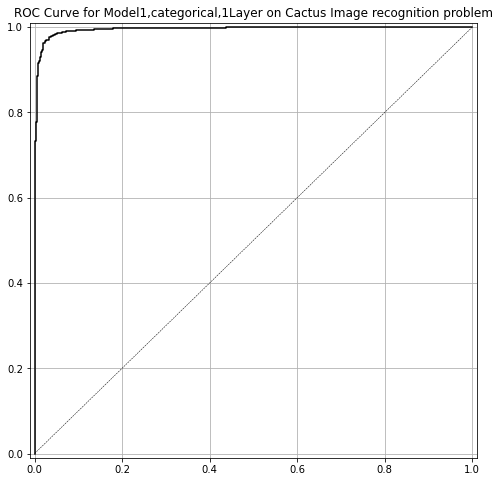

In [25]:
# plotting the roc curve
plot_roc(y_prob, 'Model1,categorical,1Layer')

### Model 2: 
#### Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification (loss = 'binary')

In [26]:
model_2 = Sequential()

## 5x5 convolution(kernel size) with 2x2 stride and 32 filters
model_2.add(Conv2D(32, (5,5), strides =(2,2), padding='same',
                  input_shape= x_train.shape[1:]))
model_2.add(Activation('relu'))

## Another 5x5 convolution with 2x2 stride and 32 filters
model_2.add(Conv2D(32, (5,5), strides =(2,2)))
model_2.add(Activation('relu'))

## 2x2 max pooling reduces to 3 x 3 x 32
model_2.add(MaxPooling2D(pool_size=(2,2)))
model_2.add(Dropout(0.25))

## Flatten turns 3x3x32 into 288x1
model_2 = create_dense(model_2,512,'relu',0.5,'sigmoid')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 16, 16, 32)        2432      
_________________________________________________________________
activation_4 (Activation)    (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 32)          25632     
_________________________________________________________________
activation_5 (Activation)    (None, 6, 6, 32)          0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 288)              

In [27]:
# initiate the optimizer
opt2 = keras.optimizers.RMSprop(lr = 5e-4)

compiler('Model2,binary,1Layer',model_2,opt2,'binary_crossentropy','binary_accuracy',15)

Epoch 1/15
383/383 [==============================] - 4s 9ms/step - loss: 0.3447 - binary_accuracy: 0.8560 - val_loss: 0.1874 - val_binary_accuracy: 0.9408
Epoch 2/15
383/383 [==============================] - 3s 9ms/step - loss: 0.2195 - binary_accuracy: 0.9198 - val_loss: 0.1722 - val_binary_accuracy: 0.9374
Epoch 3/15
383/383 [==============================] - 3s 9ms/step - loss: 0.1612 - binary_accuracy: 0.9422 - val_loss: 0.1135 - val_binary_accuracy: 0.9581
Epoch 4/15
383/383 [==============================] - 3s 9ms/step - loss: 0.1358 - binary_accuracy: 0.9512 - val_loss: 0.1181 - val_binary_accuracy: 0.9567
Epoch 5/15
383/383 [==============================] - 3s 9ms/step - loss: 0.1255 - binary_accuracy: 0.9550 - val_loss: 0.0897 - val_binary_accuracy: 0.9709
Epoch 6/15
383/383 [==============================] - 3s 9ms/step - loss: 0.1117 - binary_accuracy: 0.9620 - val_loss: 0.0876 - val_binary_accuracy: 0.9709
Epoch 7/15
383/383 [==============================] - 3s 9ms/ste

In [28]:
y_pred, y_prob = calc_proba('Model2,binary,1Layer', model_2)

Precision : 0.981
Recall : 0.991
ROC-AUC score : 0.996


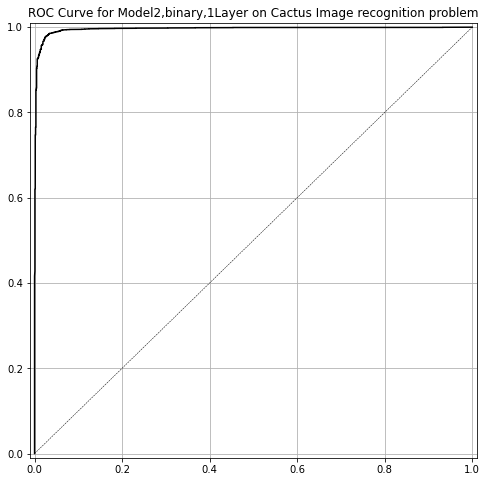

In [29]:
# plotting the roc curve
plot_roc(y_prob, 'Model2,binary,1Layer')

### Model 3: 
#### Conv -> Conv -> MaxPool -> Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification (loss = 'binary')

In [30]:
model_3 = Sequential()

## 3x3 convolution(kernel size) with 1x1 stride and 32 filters
model_3.add(Conv2D(32, (3,3), padding='same',
                  input_shape= x_train.shape[1:]))
model_3.add(Activation('relu'))
model_3.add(Conv2D(32, (3,3)))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2,2)))
model_3.add(Dropout(0.25))

model_3.add(Conv2D(64, (3,3), padding='same'))
model_3.add(Activation('relu'))
model_3.add(Conv2D(64, (3,3)))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2,2)))
model_3.add(Dropout(0.25))
            
## Flatten turns 3x3x32 into 288x1
model_3 = create_dense(model_3,512,'relu',0.5,'sigmoid')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_9 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 15, 64)       

In [31]:
# initiate the optimizer
opt3 = keras.optimizers.RMSprop(lr = 5e-4)

compiler('Model3,binary,2Layer',model_3,opt3,'binary_crossentropy','binary_accuracy',15)

Epoch 1/15
383/383 [==============================] - 22s 57ms/step - loss: 0.2345 - binary_accuracy: 0.9057 - val_loss: 0.1078 - val_binary_accuracy: 0.9606
Epoch 2/15
383/383 [==============================] - 22s 56ms/step - loss: 0.1254 - binary_accuracy: 0.9539 - val_loss: 0.0782 - val_binary_accuracy: 0.9697
Epoch 3/15
383/383 [==============================] - 22s 57ms/step - loss: 0.0856 - binary_accuracy: 0.9698 - val_loss: 0.0574 - val_binary_accuracy: 0.9807
Epoch 4/15
383/383 [==============================] - 22s 57ms/step - loss: 0.0702 - binary_accuracy: 0.9761 - val_loss: 0.0495 - val_binary_accuracy: 0.9847
Epoch 5/15
383/383 [==============================] - 23s 59ms/step - loss: 0.0577 - binary_accuracy: 0.9796 - val_loss: 0.0387 - val_binary_accuracy: 0.9851
Epoch 6/15
383/383 [==============================] - 24s 61ms/step - loss: 0.0536 - binary_accuracy: 0.9818 - val_loss: 0.0540 - val_binary_accuracy: 0.9819
Epoch 7/15
383/383 [==============================] 

In [32]:
y_pred, y_prob = calc_proba('Model3,binary,2Layer', model_3)

Precision : 0.997
Recall : 0.992
ROC-AUC score : 1.000


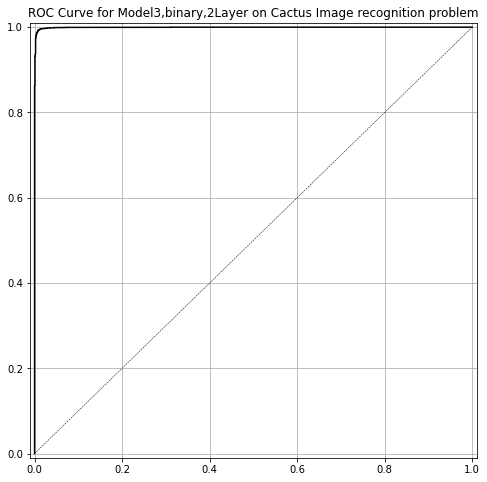

In [33]:
# plotting the roc curve
plot_roc(y_prob, 'Model3,binary,2Layer')

#### Plotting the training and validation loss and accuracies for the 3 base models:

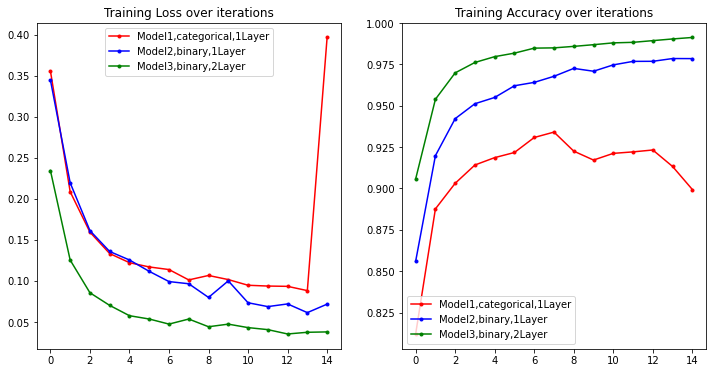

In [34]:
plot_accuracy_loss(0,2,False) # False for Training plots

> - There is a steady decrease in the training loss for the first 3 models as the 
number of epochs increase 
> - With two deep layers and binary crossentropy loss, Model 3 has the lowest loss for same epochs 
> - There is a steady increase in the training accuracy for the binary crossentropy models where as the categorical crossentropy model increases its accuracy upto epoch=7 and then decreases gradually
> - Model 3 has highest training accuracy right from the beginning and achieves a stable value=0.99 already around 10 epochs

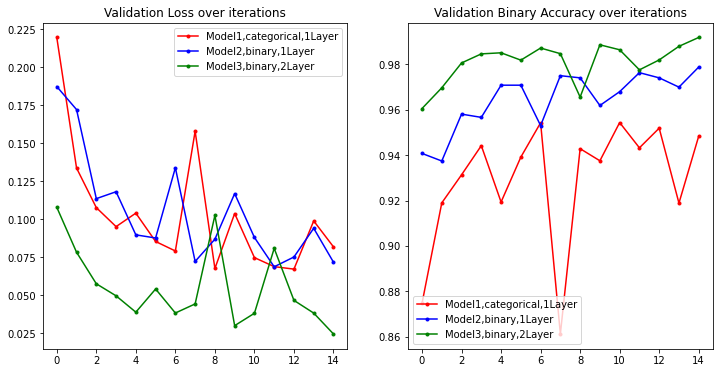

In [35]:
plot_accuracy_loss(0,2,True) # True for Validation plots

> - All Models have fluctuations in the losses, which could mean that there is overfitting the data. 
> - However, Model 3 has the lowest loss among all almost throughout the iterations
> - For validation accuracy, Model 1 has huge fluctuations and it decreases after epoch=6, which could mean overfitting
> - Model 3 validation accuracy increases very steadily upwards, although there are also minor fluctuations in between

>__Since Model 3 gives already very good validation accuracy of approx 0.99 and lower loss at around epoch 10 , I will take it as a basis with 10 epochs for further hypertuning__

### Model 4: 
#### Conv -> Conv -> MaxPool -> Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification (Base = Model 3, epochs = 10)

In [36]:
model_4 = Sequential()

model_4.add(Conv2D(32, (3,3), padding='same',
                  input_shape= x_train.shape[1:]))
model_4.add(Activation('relu'))
model_4.add(Conv2D(32, (3,3)))
model_4.add(Activation('relu'))
model_4.add(MaxPooling2D(pool_size=(2,2)))
model_4.add(Dropout(0.25))

model_4.add(Conv2D(64, (3,3), padding='same'))
model_4.add(Activation('relu'))
model_4.add(Conv2D(64, (3,3)))
model_4.add(Activation('relu'))
model_4.add(MaxPooling2D(pool_size=(2,2)))
model_4.add(Dropout(0.25))
            
model_4 = create_dense(model_4,512,'relu',0.5,'sigmoid')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_14 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_15 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 15, 15, 64)       

In [37]:
# initiate the optimizer
opt4 = keras.optimizers.RMSprop(lr = 5e-4)

compiler('Model4,RMSp,lr=5e-4',model_4,opt4,'binary_crossentropy','binary_accuracy',10)

Epoch 1/10
383/383 [==============================] - 22s 57ms/step - loss: 0.2376 - binary_accuracy: 0.9008 - val_loss: 0.1022 - val_binary_accuracy: 0.9660
Epoch 2/10
383/383 [==============================] - 22s 56ms/step - loss: 0.1125 - binary_accuracy: 0.9583 - val_loss: 0.1685 - val_binary_accuracy: 0.9442
Epoch 3/10
383/383 [==============================] - 21s 55ms/step - loss: 0.0826 - binary_accuracy: 0.9698 - val_loss: 0.0734 - val_binary_accuracy: 0.9747
Epoch 4/10
383/383 [==============================] - 21s 56ms/step - loss: 0.0627 - binary_accuracy: 0.9780 - val_loss: 0.0470 - val_binary_accuracy: 0.9820
Epoch 5/10
383/383 [==============================] - 22s 57ms/step - loss: 0.0590 - binary_accuracy: 0.9826 - val_loss: 0.0444 - val_binary_accuracy: 0.9837
Epoch 6/10
383/383 [==============================] - 22s 56ms/step - loss: 0.0486 - binary_accuracy: 0.9844 - val_loss: 0.0475 - val_binary_accuracy: 0.9848
Epoch 7/10
383/383 [==============================] 

In [38]:
y_pred, y_prob = calc_proba('Model4,RMSp,lr=5e-4', model_4)

Precision : 0.997
Recall : 0.977
ROC-AUC score : 0.998


### Model 5: 
#### Conv -> Conv -> MaxPool -> Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification (Base = Model 4, optimizer = Adam)

In [39]:
model_5 = Sequential()

model_5.add(Conv2D(32, (3,3), padding='same',
                  input_shape= x_train.shape[1:]))
model_5.add(Activation('relu'))
model_5.add(Conv2D(32, (3,3)))
model_5.add(Activation('relu'))
model_5.add(MaxPooling2D(pool_size=(2,2)))
model_5.add(Dropout(0.25))

model_5.add(Conv2D(64, (3,3), padding='same'))
model_5.add(Activation('relu'))
model_5.add(Conv2D(64, (3,3)))
model_5.add(Activation('relu'))
model_5.add(MaxPooling2D(pool_size=(2,2)))
model_5.add(Dropout(0.25))
            
model_5 = create_dense(model_5,512,'relu',0.5,'sigmoid')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_20 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_21 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 15, 15, 64)       

In [40]:
# initiate the optimizer
opt5 = keras.optimizers.Adam(lr = 5e-4)

compiler('Model5,Adam,lr=5e-4',model_5,opt5,'binary_crossentropy','binary_accuracy',10)

Epoch 1/10
383/383 [==============================] - 20s 53ms/step - loss: 0.2258 - binary_accuracy: 0.9043 - val_loss: 0.1551 - val_binary_accuracy: 0.9414
Epoch 2/10
383/383 [==============================] - 20s 53ms/step - loss: 0.0949 - binary_accuracy: 0.9653 - val_loss: 0.0592 - val_binary_accuracy: 0.9784
Epoch 3/10
383/383 [==============================] - 21s 54ms/step - loss: 0.0580 - binary_accuracy: 0.9788 - val_loss: 0.0569 - val_binary_accuracy: 0.9786
Epoch 4/10
383/383 [==============================] - 20s 53ms/step - loss: 0.0509 - binary_accuracy: 0.9816 - val_loss: 0.0690 - val_binary_accuracy: 0.9750
Epoch 5/10
383/383 [==============================] - 20s 52ms/step - loss: 0.0394 - binary_accuracy: 0.9860 - val_loss: 0.0399 - val_binary_accuracy: 0.9869
Epoch 6/10
383/383 [==============================] - 20s 51ms/step - loss: 0.0342 - binary_accuracy: 0.9885 - val_loss: 0.0297 - val_binary_accuracy: 0.9889
Epoch 7/10
383/383 [==============================] 

In [41]:
y_pred, y_prob = calc_proba('Model5,Adam,lr=5e-4', model_5)

Precision : 0.999
Recall : 0.989
ROC-AUC score : 0.999


> One can see from above that Model 5 with __'Adam' optimizer is faster than 'RMSprop' optimizer__ and produces better Precision and recall values in the range of 0.99 than Model 4

> Hence I would use this model as a base to increase the learning rate for the final variant

### Model 6: 
#### Conv -> Conv -> MaxPool -> Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification (Base = Model 5, lr = 5e-3)

In [42]:
model_6 = Sequential()

model_6.add(Conv2D(32, (3,3), padding='same',
                  input_shape= x_train.shape[1:]))
model_6.add(Activation('relu'))
model_6.add(Conv2D(32, (3,3)))
model_6.add(Activation('relu'))
model_6.add(MaxPooling2D(pool_size=(2,2)))
model_6.add(Dropout(0.25))

model_6.add(Conv2D(64, (3,3), padding='same'))
model_6.add(Activation('relu'))
model_6.add(Conv2D(64, (3,3)))
model_6.add(Activation('relu'))
model_6.add(MaxPooling2D(pool_size=(2,2)))
model_6.add(Dropout(0.25))
            
model_6 = create_dense(model_6,512,'relu',0.5,'sigmoid')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_26 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_27 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 15, 15, 64)       

In [43]:
# initiate the optimizer
opt6 = keras.optimizers.Adam(lr = 5e-3)

compiler('Model6,Adam,lr=5e-3',model_6,opt6,'binary_crossentropy','binary_accuracy',10)

Epoch 1/10
383/383 [==============================] - 21s 54ms/step - loss: 0.5659 - binary_accuracy: 0.7501 - val_loss: 0.5672 - val_binary_accuracy: 0.7507
Epoch 2/10
383/383 [==============================] - 20s 53ms/step - loss: 0.5650 - binary_accuracy: 0.7506 - val_loss: 0.5621 - val_binary_accuracy: 0.7507
Epoch 3/10
383/383 [==============================] - 20s 53ms/step - loss: 0.5644 - binary_accuracy: 0.7506 - val_loss: 0.5617 - val_binary_accuracy: 0.7507
Epoch 4/10
383/383 [==============================] - 21s 54ms/step - loss: 0.5639 - binary_accuracy: 0.7506 - val_loss: 0.5634 - val_binary_accuracy: 0.7507
Epoch 5/10
383/383 [==============================] - 20s 53ms/step - loss: 0.5639 - binary_accuracy: 0.7506 - val_loss: 0.5640 - val_binary_accuracy: 0.7507
Epoch 6/10
383/383 [==============================] - 21s 54ms/step - loss: 0.5637 - binary_accuracy: 0.7506 - val_loss: 0.5623 - val_binary_accuracy: 0.7507
Epoch 7/10
383/383 [==============================] 

In [44]:
y_pred, y_prob = calc_proba('Model6,Adam,lr=5e-3', model_6)

Precision : 0.751
Recall : 1.000
ROC-AUC score : 0.500


> The __increased learning rate__ reduces the validation accuracy considerably and increases the loss also. The Precision score has reduced to 0.75. Hence this Model won't be considered

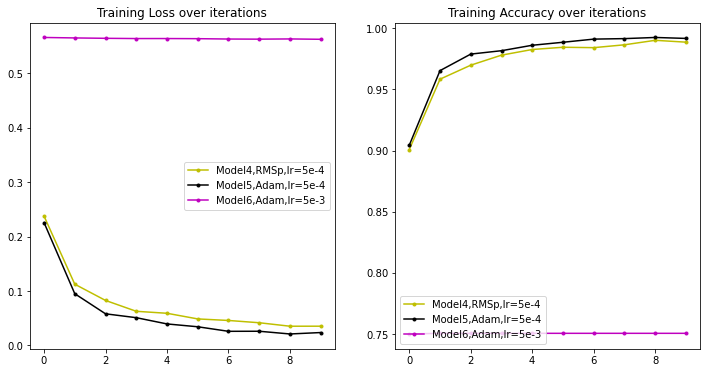

In [45]:
plot_accuracy_loss(3,5,False) # False for Training plots

> - Here, Models 4 and 5 with a lower learning rate outperform Model 6, which has a ten times higher learning rate and due to this, probably has a more zigzag pattern and overshoots the global minimum, resulting in constant higher training losses
> - Also in terms of Training accuracy, both Models 4 and 5 are very close to each other and outperform Model 6

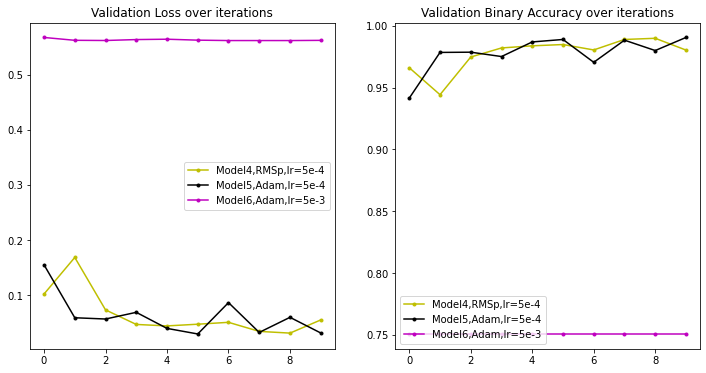

In [46]:
plot_accuracy_loss(3,5,True) # True for Validation plots

> - Same holds for the validation set also, both in terms of loss and accuracies
> - One can see that although the __Adam__ optimizer fluctuates more than the __RMS__ optimizer, but later at epoch=10 has a slightly higher accuracy and a lower loss
> - Also the training time of Adam optimizer is much faster than the RMSprop optimizer, which can be siginificant for large datasets

### Best Model:
> Based on the above discussions, both Models 4 and 5 have very high precision of 0.997 and 0.998 as seen from the scores_ table below.  
> But Model 5 trains slightly faster than Model 4 and has a slightly higher validation accuracy at epoch 10

Hence the best Model is 

|Model|Deep Layers|Final Activation|Loss Function|No. of Epochs|Optimizer|Learning Rate|
|---|---|---|---|---|---|---|
|5|2|sigmoid|binary crossentropy|10|Adam|5e-4|

In [47]:
scores_.sort_values(by='Precision', ascending=False)

,Model,Precision,Recall,ROC-AUC score
4,"Model5,Adam,lr=5e-4",0.9987,0.9886,0.9993
2,"Model3,binary,2Layer",0.9974,0.9916,0.9995
3,"Model4,RMSp,lr=5e-4",0.9969,0.9767,0.9985
0,"Model1,categorical,1Layer",0.9917,0.967,0.9948
1,"Model2,binary,1Layer",0.9807,0.9914,0.9959
5,"Model6,Adam,lr=5e-3",0.7507,1.0,0.5


In [48]:
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_20 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_21 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 15, 15, 64)       